In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.keys()

c:\Users\magenta\.conda\envs\KDT\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
y = y.astype(np.uint8)

In [5]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [6]:
enc.fit(y[:,np.newaxis])

C:\Users\magenta\AppData\Local\Temp\ipykernel_10908\4241405308.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  enc.fit(y[:,np.newaxis])


OneHotEncoder()

In [7]:
Y = enc.transform(y[:,np.newaxis]).toarray()

C:\Users\magenta\AppData\Local\Temp\ipykernel_10908\752173705.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Y = enc.transform(y[:,np.newaxis]).toarray()


In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], Y[:60000], Y[60000:]

In [9]:
X_train = X_train / 255
X_test = X_test / 255

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def softmax(X, W):
    K = np.size(W, 1)
    A = np.exp(X @ W)
    B = np.diag(1 / (np.reshape(A @ np.ones((K,1)), -1)))
    Y = B @ A
    return Y

In [12]:
# def compute_cost(X, T, W, Lambda):
#     epsilon = 1e-5
#     N = len(T)
#     K = np.size(T, 1)
#     cost = - (1/N) * np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1))

#     return cost

def compute_cost(X, T, W, Lambda = 0):
    epsilon = 1e-5
    N = len(T)
    K = np.size(T, 1)
    cost = - (1/N) * (np.ones((1,N)) @ (np.multiply(np.log(softmax(X, W) + epsilon), T)) @ np.ones((K,1)) + Lambda * np.sum(W ** 2) / 2 )

    return cost

    

In [13]:
def predict(X, W):
    return np.argmax((X @ W), axis=1)

In [14]:
def batch_gd(X, T, W, learning_rate, iterations, batch_size, Lambda = 0):
    N = len(T)
    cost_history = np.zeros((iterations,1))
    shuffled_indices = np.random.permutation(N)
    X_shuffled = X[shuffled_indices]
    T_shuffled = T[shuffled_indices]

    for i in range(iterations):
        j = i % N
        X_batch = X_shuffled[j:j+batch_size]
        T_batch = T_shuffled[j:j+batch_size]
        # batch가 epoch 경계를 넘어가는 경우, 앞 부분으로 채워줌
        if X_batch.shape[0] < batch_size:
            X_batch = np.vstack((X_batch, X_shuffled[:(batch_size - X_batch.shape[0])]))
            T_batch = np.vstack((T_batch, T_shuffled[:(batch_size - T_batch.shape[0])]))
        # W = W - (learning_rate/batch_size) * (X_batch.T @ (softmax(X_batch, W) - T_batch))
        W = W - (learning_rate/batch_size) * ( (X_batch.T @ (softmax(X_batch, W) - T_batch)) + Lambda * W )
        cost_history[i] = compute_cost(X_batch, T_batch, W, Lambda)
        if i % 1000 == 0:
            print(cost_history[i][0])

    return (cost_history, W)

In [15]:
X = np.hstack((np.ones((np.size(X_train, 0),1)),X_train))
T = y_train

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

iterations = 50000
learning_rate = 0.01

initial_cost = compute_cost(X, T, W)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64)

Initial Cost is: 2.3024850979936966 

2.283882156142858
0.6471026873122138
0.4075718571711726
0.445964705678682
0.42175015859065745
0.5572718187184778
0.39202254871228476
0.2481189525679637
0.2890517758865918
0.2388043661900653
0.30749493497037106
0.14393463527629136
0.23344151985164466
0.22956561096571168
0.26486331222775106
0.40924608073542307
0.23822606748319347
0.377230552285167
0.17755738410659525
0.3755394768729536
0.17891406150225653
0.21060780827383013
0.18603478488037392
0.3325587895391606
0.2836318667036142
0.26936063104426955
0.23056896400151097
0.2599954605043212
0.19322720193137982
0.20728775378273398
0.2229404324721986
0.24421966489641325
0.3466699953517009
0.24998941038860836
0.3315191182972881
0.19425753550179914
0.2870887999176378
0.201772028550349
0.2432641773553778
0.3188479795304069
0.3700207572139579
0.13253069148381968
0.18348375870214506
0.42472281166801984
0.4633514031425306
0.27326784523050784
0.24930112948325883
0.5455634404004067
0.20455055493284988
0.2362317

In [16]:
## Accuracy
X_ = np.hstack((np.ones((np.size(X_test, 0),1)),X_test))
T_ = y_test
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.9127


In [17]:
_X_train, _X_val = X[:50000], X[50000:]
T_train, T_val = T[:50000], T[50000:]

K = np.size(T_train, 1)
M = np.size(_X_train, 1)

iterations = 50000
learning_rate = 0.01

best_score = 0.0
best_W_optimal = np.zeros((M,K))
Lambda_list = [0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.5]
accuracy_history = np.zeros((len(Lambda_list),2))



In [18]:
for idx, Lambda in enumerate(Lambda_list) :
    W = np.zeros((M,K))

    initial_cost = compute_cost(_X_train, T_train, W, Lambda)
    print("Initial Cost is: {} \n".format(initial_cost[0][0]))

    (cost_history, W_optimal) = batch_gd(_X_train, T_train, W, learning_rate, iterations, 64, Lambda)

    y_pred = predict(_X_val, W_optimal)
    score = float(sum(y_pred == np.argmax(T_val, axis=1)))/ float(len(T_val))

    accuracy_history[idx][0] = Lambda
    accuracy_history[idx][1] = score
    print(score)
    if score > best_score :
        best_score = score
        best_W_optimal = W_optimal

Initial Cost is: 2.3024850979937015 

2.278732172056426
0.5746696415238992
0.48522606534058266
0.3996280363666491
0.4672561150574395
0.36536614089686914
0.4569680343341279
0.4063632417461962
0.2556322816110136
0.22636499515358088
0.34115642210046543
0.17241375866991956
0.44516396515331913
0.2854823213953948
0.3832520012063503
0.20012309168820602
0.26810879907634005
0.15488579059790628
0.23763621696127274
0.46962358071130206
0.4186057056049493
0.3454452929570746
0.2760154305532102
0.21701039939986974
0.388073288848175
0.34428146247849556
0.24839804301738064
0.4457375530984939
0.2829193612526652
0.27489869903714287
0.2784969200697248
0.2733897083548355
0.21172187310261473
0.268524535568325
0.28958285087151286
0.1852437577362158
0.15841148350866247
0.136029923056457
0.23679767175879265
0.29503889502400704
0.2241403050013535
0.3715226341328245
0.13565515526044877
0.3672807513889698
0.3251156465002396
0.26676529558954964
0.3312036531742032
0.17403663043541887
0.22729979223969723
0.270533771

In [19]:
print(accuracy_history)

[[0.     0.9177]
 [0.001  0.9198]
 [0.005  0.9117]
 [0.01   0.9165]
 [0.02   0.9179]
 [0.03   0.9131]
 [0.05   0.9189]
 [0.1    0.9153]
 [0.5    0.8983]]


In [20]:

K = np.size(T, 1)
M = np.size(X, 1)
W = np.zeros((M,K))

best_lambda = accuracy_history[np.argmax(accuracy_history, axis = 0)[1], 0] 
initial_cost = compute_cost(X, T, W, best_lambda)

print("Initial Cost is: {} \n".format(initial_cost[0][0]))

(cost_history, W_optimal) = batch_gd(X, T, W, learning_rate, iterations, 64, best_lambda)

Initial Cost is: 2.3024850979936966 

2.283035168946992
0.6877526063987381
0.6663499071417164
0.4397606326915725
0.3157308060492091
0.42136013364907793
0.29634938249560383
0.2605111388109073
0.3032704489288523
0.34219643839513514
0.5862361621058944
0.17071638215819976
0.25697291400695976
0.2796393646430855
0.19018198027395683
0.34484265493638716
0.2497090497381088
0.4481279389022922
0.4238458811029597
0.20340970286403542
0.10613035571428593
0.1283707222833785
0.3966943414329238
0.35313605740178566
0.20723420687752028
0.3109482467149145
0.30698332417696633
0.20737591449020557
0.26025917915824015
0.2745350721203229
0.4555177135012555
0.2929027529517524
0.12690274392338985
0.31591369905778216
0.19814445197547698
0.4002488439950632
0.13541098048677563
0.2637654080553362
0.4864083229343169
0.20821225330337143
0.2929342822753091
0.2807859521628373
0.2616428932986501
0.17239526835392793
0.3079875606268397
0.1422800140588999
0.1909186456111655
0.17786943696322483
0.17631922282171403
0.21073584

In [21]:
y_pred = predict(X_, W_optimal)
score = float(sum(y_pred == np.argmax(T_, axis=1)))/ float(len(y_test))

print(score)

0.9144


training score : 0.995 (multinomial)


C:\Users\magenta\AppData\Local\Temp\ipykernel_10908\948090961.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


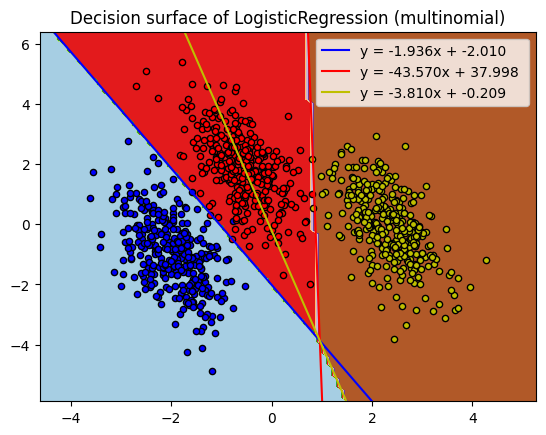

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

clf = LogisticRegression(
    solver="sag", max_iter=100, random_state=42, multi_class="multinomial"
).fit(X, y)

# print the training scores
print("training score : %.3f (%s)" % (clf.score(X, y),"multinomial"))

_, ax = plt.subplots()
DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict", cmap=plt.cm.Paired, ax=ax
)
plt.title("Decision surface of LogisticRegression (%s)" % "multinomial")
plt.axis("tight")

# Plot also the training points
colors = "bry"
for i, color in zip(clf.classes_, colors):
    idx = np.where(y == i)
    plt.scatter(
        X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor="black", s=20
    )

# Plot the three one-against-all classifiers
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
coef = clf.coef_
intercept = clf.intercept_
eps = 1e-3

decision_boundary = [list() for _ in range(len(clf.classes_))]

def plot_hyperplane(c, color):
    w = - (coef[c, 0] - coef[(c+1) % 3, 0]) / (coef[c, 1] - coef[(c+1) % 3, 1])
    b = - (intercept[c] - intercept[(c+1) % 3]) / (coef[c, 1] - coef[(c+1) % 3, 1])
    def line(x0):
    #    return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        return w*x0 + b

    plt.plot([xmin, xmax], [line(xmin), line(xmax)], color=color, label = 'y = {:.03f}x + {:.03f} '.format(w, b))

for i, color in zip(clf.classes_, colors):
    plot_hyperplane(i, color)

plt.legend()
plt.show()